In [51]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
data_dir = '/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control.h5'

In [53]:
f = h5py.File(data_dir, 'r')
f.keys()

<KeysViewHDF5 ['images', 'layer_maps', 'layer_names', 'patient_indices', 'splits']>

In [54]:
images = f['images']
layers = f['layer_maps']
layer_names = f['layer_names']
images, layers, layer_names

(<HDF5 dataset "images": shape (5088, 512, 1000), type "<f4">,
 <HDF5 dataset "layer_maps": shape (5088, 1000, 3), type "<f4">,
 <HDF5 dataset "layer_names": shape (3,), type "|S16">)

In [47]:
def plot_bscan_with_layers(idx):
    """Plot B-scan with layer annotations"""
    # Get data
    image = f['images'][idx]
    layers = f['layer_maps'][idx]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot B-scan
    plt.imshow(image, cmap='viridis', aspect='auto')
    
    # Plot layer annotations
    x_coords = np.arange(1000)
    colors = ['red', 'green', 'blue']
    layer_names = [name.decode() for name in f['layer_names']]
    
    for i, (color, name) in enumerate(zip(colors, layer_names)):
        plt.plot(x_coords, layers[:, i], color=color, label=name, linewidth=1)
    
    plt.title(f'B-scan {idx} with Layer Annotations')
    plt.legend(loc='upper right')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

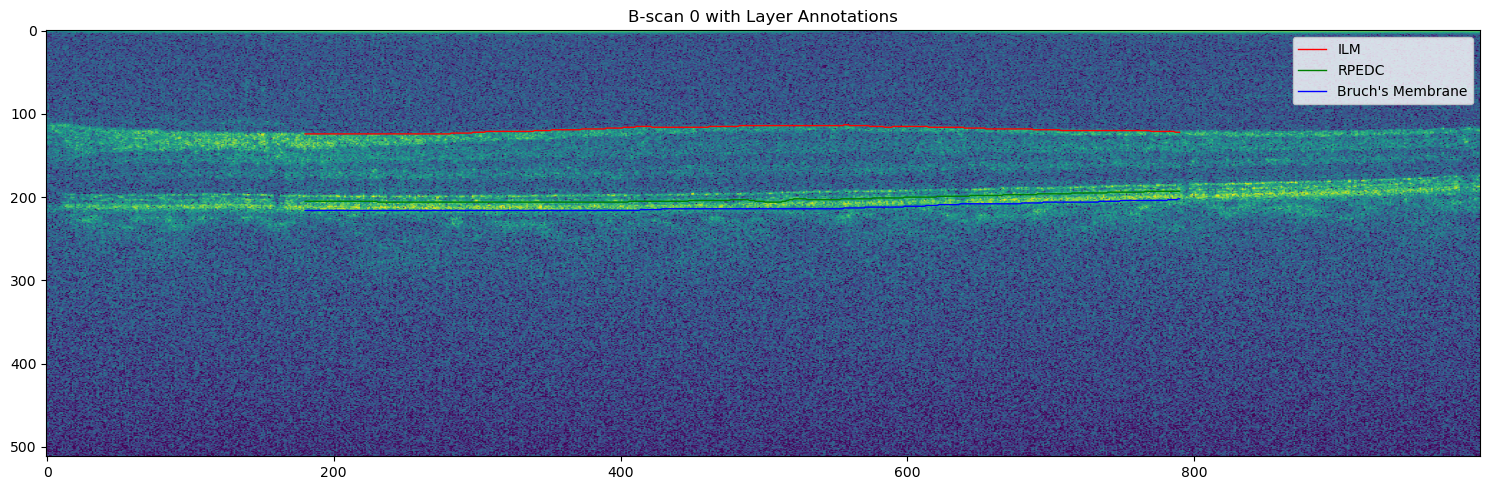

In [73]:
# Visualize a few examples
example_indices = [0]
for idx in example_indices:
    plot_bscan_with_layers(idx)

In [55]:
#Checking if the images are normalized
img = f['images'][0]
print("dtype:", img.dtype)
print("min:", img.min())
print("max:", img.max())
print("mean:", img.mean())

dtype: float32
min: 0.0
max: 1.0
mean: 0.28818762


In [56]:
# Checking if the layer_maps are normalized
layer = f['layer_maps'][0]
print("dtype:", layer.dtype)
print("min:", layer.min())
print("max:", layer.max())
print("mean:", layer.mean())

dtype: float32
min: nan
max: nan
mean: nan


In [57]:
# Check layer names and shape details
layer_names_decoded = [name.decode() for name in f['layer_names']]
print("Layer names:", layer_names_decoded)
print("Images shape:", f['images'].shape)  # (5088, 512, 1000)
print("Layer_maps shape:", f['layer_maps'].shape)  # (5088, 1000, 3)

# Check a specific layer map to understand the NaN issue
sample_layer = f['layer_maps'][0]
print("\nSample layer map stats:")
print("Shape:", sample_layer.shape)
print("Has NaN values:", np.isnan(sample_layer).any())
print("Number of NaN values:", np.isnan(sample_layer).sum())

# Check valid (non-NaN) values
valid_mask = ~np.isnan(sample_layer)
if valid_mask.any():
    valid_values = sample_layer[valid_mask]
    print("Valid values min:", valid_values.min())
    print("Valid values max:", valid_values.max())
    print("Valid values mean:", valid_values.mean())

Layer names: ['ILM', 'RPEDC', "Bruch's Membrane"]
Images shape: (5088, 512, 1000)
Layer_maps shape: (5088, 1000, 3)

Sample layer map stats:
Shape: (1000, 3)
Has NaN values: True
Number of NaN values: 1167
Valid values min: 113.0
Valid values max: 216.0
Valid values mean: 177.67758


In [79]:
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
import cv2

def process_bscan_data(images, layer_maps):
    """
    Process B-scan images and layer maps according to the requirements:
    1. Crop vertically: remove first 200 and last 200 pixels (1000 -> 600 pixels)
    2. Crop horizontally: based on ILM and BM layers with 50px margins
    3. Resize to 224x224
    
    Layer maps contain y-coordinates for each x-position, so we need to:
    - Crop the layer maps to match image width cropping
    - Adjust y-coordinates when height cropping
    - Scale coordinates when resizing
    """
    processed_images = []
    processed_layers = []
    
    for i in range(len(images)):
        image = images[i]  # Shape: (512, 1000)
        layers = layer_maps[i]  # Shape: (1000, 3) - y-coords for each x-position
        
        # Step 1: Crop vertically (width: 1000 -> 600)
        # Remove first 200 and last 200 pixels from width
        image_cropped = image[:, 200:800]  # Shape: (512, 600)
        layers_cropped = layers[200:800, :]  # Shape: (600, 3) - keep corresponding x-positions
        
        # Step 2: Crop horizontally (height) based on layer boundaries
        # Find valid (non-NaN) layer points in the cropped data
        valid_mask = ~np.isnan(layers_cropped)
        
        if valid_mask.any():
            # Get ILM (index 0) and BM (index 2) layers
            ilm_layer = layers_cropped[:, 0]
            bm_layer = layers_cropped[:, 2]
            
            # Find valid points for each layer
            valid_ilm = ilm_layer[~np.isnan(ilm_layer)]
            valid_bm = bm_layer[~np.isnan(bm_layer)]
            
            if len(valid_ilm) > 0 and len(valid_bm) > 0:
                # Find top and bottom bounds with 50px margins
                top_bound = max(0, int(valid_ilm.min()) - 50)
                bottom_bound = min(512, int(valid_bm.max()) + 50)
                
                # Ensure we have at least some height
                if bottom_bound - top_bound < 100:
                    # Fall back to a reasonable default
                    top_bound = 100
                    bottom_bound = 400
            else:
                # Fall back to default cropping if no valid layers
                top_bound = 100
                bottom_bound = 400
        else:
            # Fall back to default cropping if no valid layers
            top_bound = 100
            bottom_bound = 400
        
        # Crop image height
        image_h_cropped = image_cropped[top_bound:bottom_bound, :]
        
        # Adjust layer y-coordinates to match the height cropping
        layers_adjusted = layers_cropped.copy()
        # Subtract top_bound from all y-coordinates to adjust for height crop
        for j in range(layers_adjusted.shape[1]):
            valid_indices = ~np.isnan(layers_adjusted[:, j])
            if valid_indices.any():
                layers_adjusted[valid_indices, j] -= top_bound
                # Clamp to valid range after adjustment
                layers_adjusted[valid_indices, j] = np.clip(
                    layers_adjusted[valid_indices, j], 
                    0, 
                    image_h_cropped.shape[0] - 1
                )
        
        # Step 3: Resize to 224x224
        # Resize image
        image_resized = cv2.resize(image_h_cropped, (224, 224), interpolation=cv2.INTER_LINEAR)
        
        # Calculate scaling factors
        height_ratio = 224 / image_h_cropped.shape[0]
        width_ratio = 224 / 600  # 600 is the width after vertical crop
        
        # Create new layer map array for resized dimensions
        layers_resized_arr = np.full((224, 3), np.nan, dtype=np.float32)
        
        # For each layer (ILM, RPE, BM)
        for layer_idx in range(3):
            layer_data = layers_adjusted[:, layer_idx]
            valid_mask = ~np.isnan(layer_data)
            
            if valid_mask.any():
                # Get valid x-positions and corresponding y-coordinates
                valid_x_positions = np.where(valid_mask)[0]  # x-positions in 600-width space
                valid_y_coords = layer_data[valid_mask]  # corresponding y-coordinates
                
                # Scale y-coordinates for height resizing
                valid_y_coords_scaled = valid_y_coords * height_ratio
                
                # Map to new width (224)
                # Original x-positions need to be mapped from 600-width to 224-width
                valid_x_scaled = valid_x_positions * width_ratio
                
                # Interpolate to get y-coordinates for all 224 x-positions
                new_x_positions = np.arange(224)
                
                if len(valid_x_scaled) > 1:
                    try:
                        # Interpolate y-coordinates for the new x-positions
                        interpolated_y = np.interp(new_x_positions, valid_x_scaled, valid_y_coords_scaled)
                        layers_resized_arr[:, layer_idx] = interpolated_y
                    except:
                        pass  # Keep NaN values if interpolation fails
        
        processed_images.append(image_resized)
        processed_layers.append(layers_resized_arr)
        
        if i % 1000 == 0:
            print(f"Processed {i}/{len(images)} images")
    
    return np.array(processed_images), np.array(processed_layers)

def normalize_layer_maps(layer_maps):
    """
    Normalize layer maps to 0-1 range based on image dimensions.
    Since layer maps contain y-coordinates in pixel space (0 to 223 after resizing),
    we normalize by dividing by the image height (224).
    """
    normalized_layers = layer_maps.copy()
    
    # Since we resized to 224x224, y-coordinates should be in range [0, 223]
    # Normalize by dividing by 223 (max possible y-coordinate) to get [0, 1] range
    valid_mask = ~np.isnan(normalized_layers)
    if valid_mask.any():
        # Clamp values to valid range first (in case of any edge cases)
        normalized_layers[valid_mask] = np.clip(normalized_layers[valid_mask], 0, 223)
        # Normalize to [0, 1] range
        normalized_layers[valid_mask] = normalized_layers[valid_mask] / 223.0
    
    return normalized_layers

In [93]:
# Process the data
print("Starting data processing...")
print(f"Original data shape - Images: {f['images'].shape}, Layer maps: {f['layer_maps'].shape}")

# Process all the data
processed_images, processed_layers = process_bscan_data(f['images'], f['layer_maps'])

print(f"After processing - Images: {processed_images.shape}, Layer maps: {processed_layers.shape}")


Starting data processing...
Original data shape - Images: (5088, 512, 1000), Layer maps: (5088, 1000, 3)
Processed 0/5088 images
Processed 1000/5088 images
Processed 1000/5088 images
Processed 2000/5088 images
Processed 2000/5088 images
Processed 3000/5088 images
Processed 3000/5088 images
Processed 4000/5088 images
Processed 4000/5088 images
Processed 5000/5088 images
Processed 5000/5088 images
After processing - Images: (5088, 224, 224), Layer maps: (5088, 224, 3)
After processing - Images: (5088, 224, 224), Layer maps: (5088, 224, 3)


In [112]:
layer = processed_layers[0]  # Example layer map for stats
print("dtype:", layer.dtype)
print("min:", layer.min())
print("max:", layer.max())
print("mean:", layer.mean())

dtype: float32
min: 55.172413
max: 168.82759
mean: 126.32025


In [97]:
def plot_bscan_with_layers(idx):
    """Plot B-scan with layer annotations"""
    # Get data
    image = processed_images[idx]
    layers = processed_layers[idx]

    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot B-scan
    plt.imshow(image, cmap='gray', aspect='auto')
    
    # Plot layer annotations
    x_coords = np.arange(224)
    colors = ['red', 'green', 'blue']
    layer_names = [name.decode() for name in f['layer_names']]
    
    for i, (color, name) in enumerate(zip(colors, layer_names)):
        plt.plot(x_coords, layers[:, i], color=color, label=name, linewidth=1)
    
    plt.title(f'B-scan {idx} with Layer Annotations')
    plt.legend(loc='upper right')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

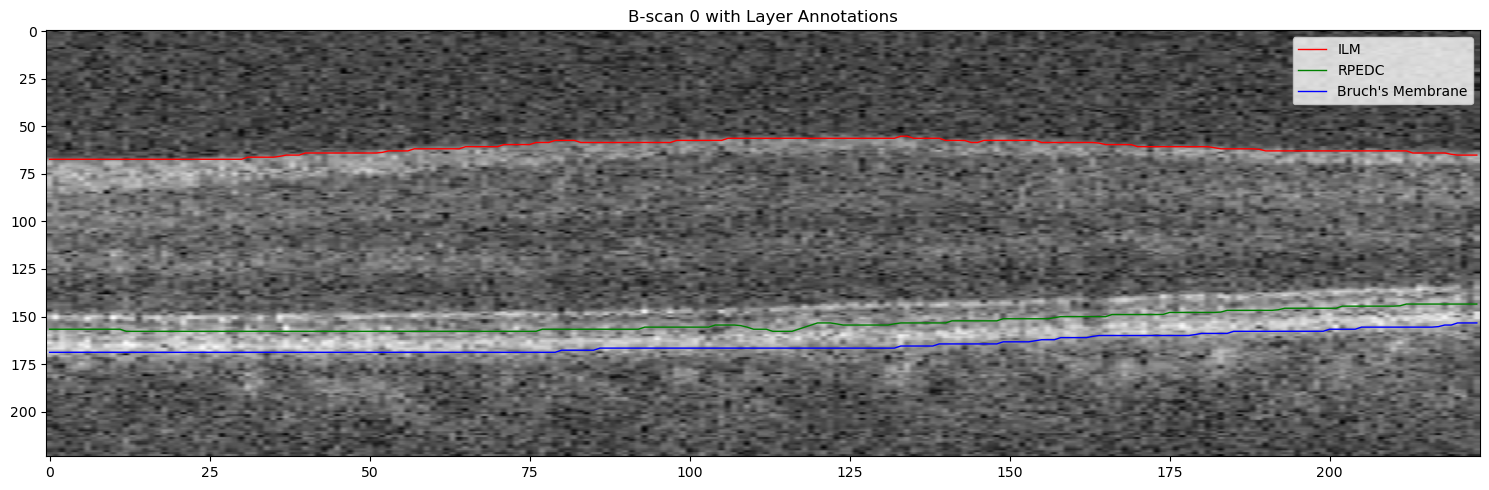

In [98]:
# Visualize a few examples
example_indices = [0]
for idx in example_indices:
    plot_bscan_with_layers(idx)

In [99]:
def normalize_layer_maps(processed_layers):
    """
    Normalize processed_layers y-coordinates to [0, 1] by dividing by 223 (for 224 height).
    processed_layers: shape (batch_size, 224, 3)
    """
    normalized = processed_layers.copy()
    valid_mask = ~np.isnan(normalized)
    normalized[valid_mask] = np.clip(normalized[valid_mask], 0, 223) / 223.0
    return normalized

In [108]:
normalized_layer_maps = normalize_layer_maps(processed_layers)

In [113]:
layer = normalized_layer_maps[0]  # Example layer map for stats
print("dtype:", layer.dtype)
print("min:", layer.min())
print("max:", layer.max())
print("mean:", layer.mean())

dtype: float32
min: 0.24740992
max: 0.7570744
mean: 0.5664586


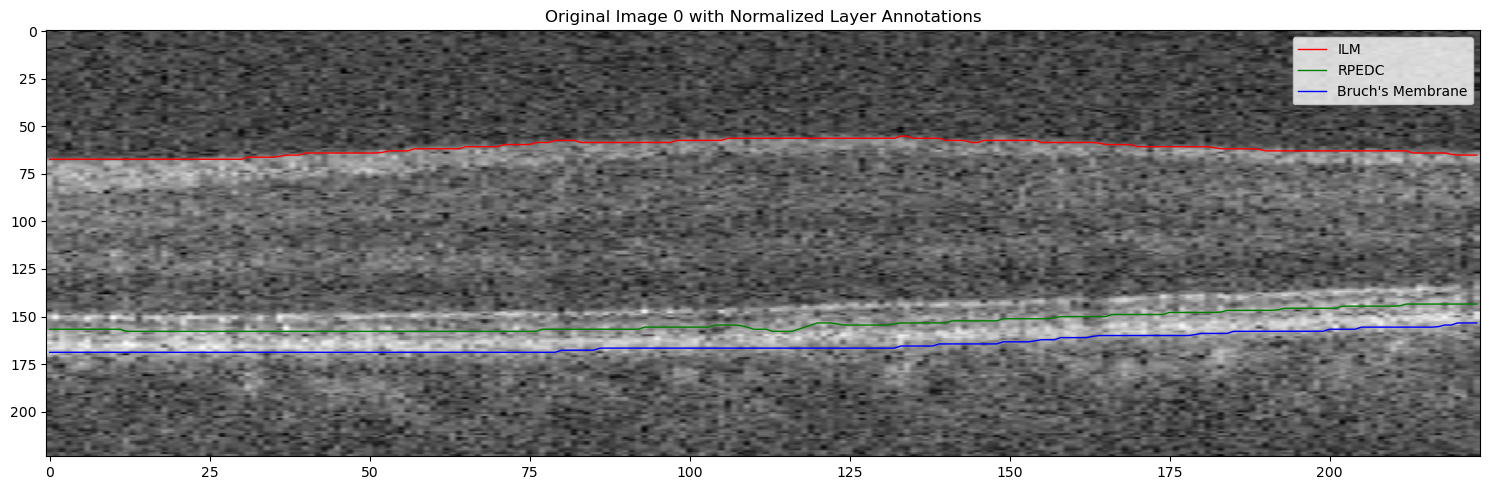

In [139]:
def plot_normalized_layers_on_original(idx, images, normalized_layer_maps, layer_names, orig_height=224):
    """
    Plot normalized layer maps (in [0,1]) on the original image.
    """
    image = images[idx]
    layers = normalized_layer_maps[idx]
    x_coords = np.arange(layers.shape[0])
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(15, 5))
    plt.imshow(image, cmap='gray', aspect='auto')
    for i, (color, name) in enumerate(zip(colors, layer_names)):
        # Denormalize y-coordinates
        y_coords = layers[:, i] * (orig_height - 1)
        plt.plot(x_coords, y_coords, color=color, label=name, linewidth=1)
    plt.title(f'Original Image {idx} with Normalized Layer Annotations')
    plt.legend(loc='upper right')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

# Example usage:
layer_names_decoded = [name.decode() for name in f['layer_names']]
plot_normalized_layers_on_original(0, processed_images, normalized_layer_maps, layer_names_decoded, orig_height=224)

In [140]:
def save_to_hdf5(output_path, images, layer_maps, layer_names):
    """
    Save processed images, normalized layer maps, and layer names to a new HDF5 file.
    Keys: 'images', 'layer_maps', 'layer_names'
    """
    with h5py.File(output_path, 'w') as f:
        f.create_dataset('images', data=images, compression='gzip', compression_opts=9)
        f.create_dataset('layer_maps', data=layer_maps, compression='gzip', compression_opts=9)
        f.create_dataset('layer_names', data=layer_names)
        f.attrs['processed'] = True
        f.attrs['description'] = 'Processed images and normalized layer maps for retinal layers'
    print(f"✅ Saved HDF5 file to: {output_path}")


In [141]:

# Example usage:
save_to_hdf5('/home/suraj/Git/SCR-Progression/Duke_Control_processed.h5', processed_images, normalized_layer_maps, f['layer_names'])

✅ Saved HDF5 file to: /home/suraj/Git/SCR-Progression/Duke_Control_processed.h5


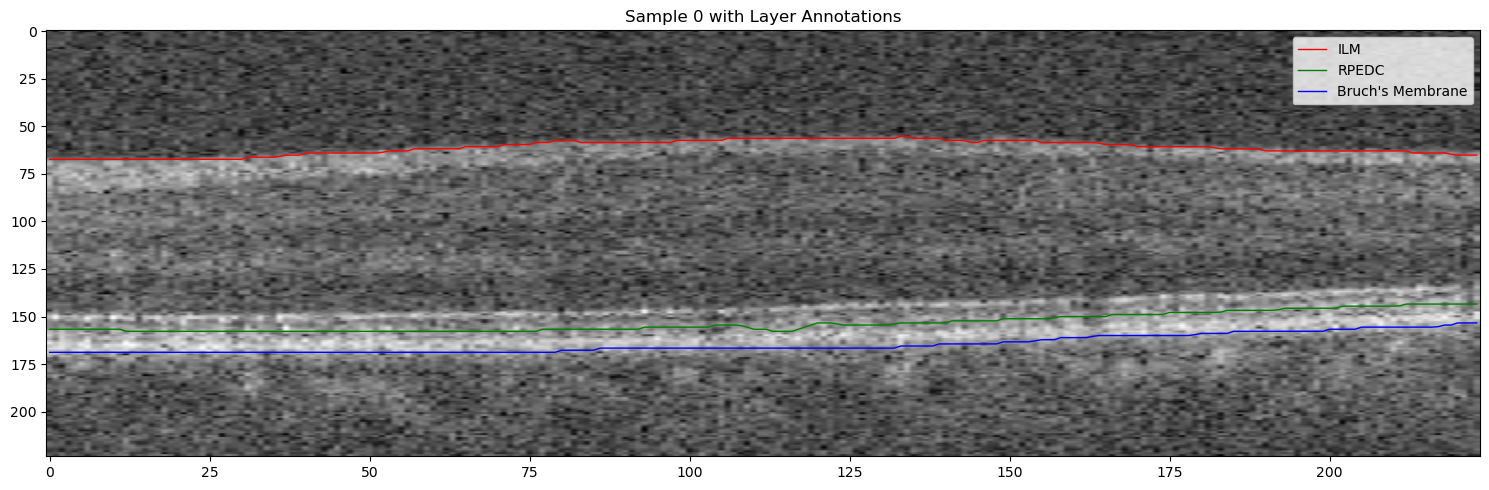

In [149]:
def plot_sample_from_h5(h5_path, idx=0):
    """
    Plot a sample image and its normalized layer annotations from a processed HDF5 file.
    """
    import h5py
    import numpy as np
    import matplotlib.pyplot as plt

    with h5py.File(h5_path, 'r') as f:
        image = f['images'][idx]
        layers = f['layer_maps'][idx]
        layer_names = [name.decode() for name in f['layer_names']]
        x_coords = np.arange(layers.shape[0])
        colors = ['red', 'green', 'blue']

        plt.figure(figsize=(15, 5))
        plt.imshow(image, cmap='gray', aspect='auto')
        for i, (color, name) in enumerate(zip(colors, layer_names)):
            # Denormalize y-coordinates for plotting
            y_coords = layers[:, i] * (image.shape[0] - 1)
            plt.plot(x_coords, y_coords, color=color, label=name, linewidth=1)
        plt.title(f'Sample {idx} with Layer Annotations')
        plt.legend(loc='upper right')
        plt.axis('on')
        plt.tight_layout()
        plt.show()

# Example usage:
#plot_sample_from_h5('/home/suraj/Data/Duke_WLOA_RL_Annotated/Duke_WLOA_Control_normalized_corrected.h5', idx=0)
plot_sample_from_h5('/home/suraj/Git/SCR-Progression/Duke_Control_processed.h5', idx=0  )  

In [142]:
data_dir = '/home/suraj/Git/SCR-Progression/Duke_Control_processed.h5'

In [143]:
f = h5py.File(data_dir, 'r')
f.keys()

<KeysViewHDF5 ['images', 'layer_maps', 'layer_names']>

In [144]:
images = f['images']
layers = f['layer_maps']
layer_names = f['layer_names']
images, layers, layer_names

(<HDF5 dataset "images": shape (5088, 224, 224), type "<f4">,
 <HDF5 dataset "layer_maps": shape (5088, 224, 3), type "<f4">,
 <HDF5 dataset "layer_names": shape (3,), type "|S16">)

In [145]:
def plot_bscan_with_layers(idx):
    """Plot B-scan with layer annotations"""
    # Get data
    image = f['images'][idx]
    layers = f['layer_maps'][idx]
    
    # Create figure
    plt.figure(figsize=(15, 5))
    
    # Plot B-scan
    plt.imshow(image, cmap='gray', aspect='auto')
    
    # Plot layer annotations
    x_coords = np.arange(layers.shape[0])
    colors = ['red', 'green', 'blue']
    layer_names = [name.decode() for name in f['layer_names']]
    
    for i, (color, name) in enumerate(zip(colors, layer_names)):
        plt.plot(x_coords, layers[:, i], color=color, label=name, linewidth=1)
    
    plt.title(f'B-scan {idx} with Layer Annotations')
    plt.legend(loc='upper right')
    plt.axis('on')
    plt.tight_layout()
    plt.show()

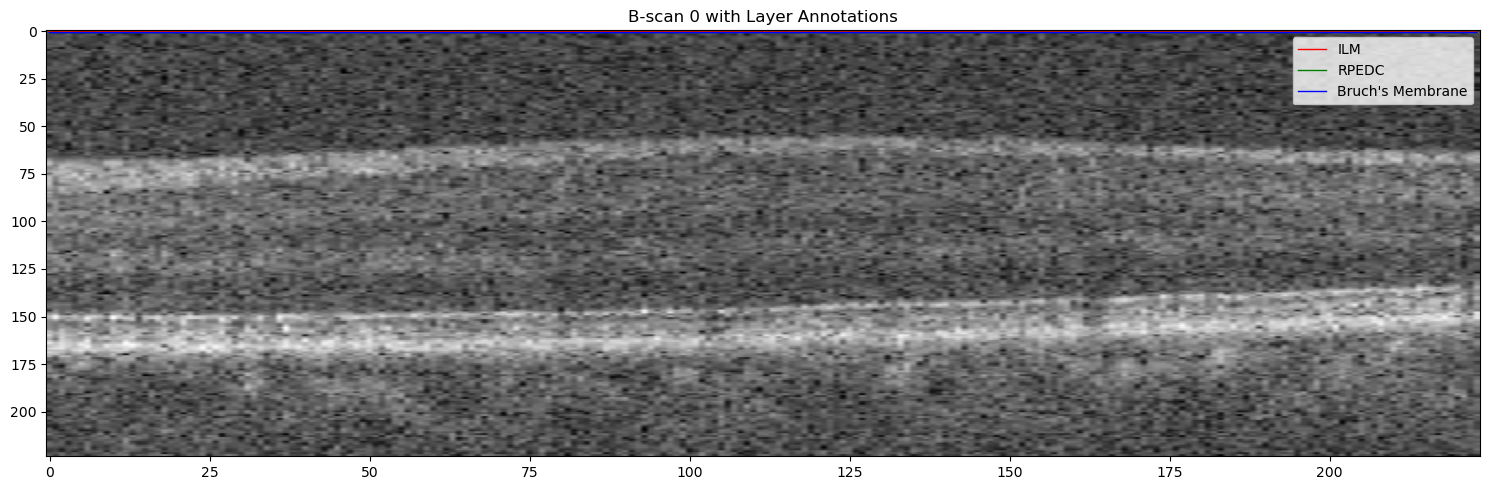

In [146]:
# Visualize a few examples
example_indices = [0]
for idx in example_indices:
    plot_bscan_with_layers(idx)